In [40]:
import sys
assert sys.version_info >= (3, 5)
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
# Estandarizador (transforma las variables en z-scores)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
def balanced_accuracy(cm): # funcion para calcular la "balanced accuracy"
  sensibilidad = cm[1,1]/(cm[1,1]+cm[0,1])
  especificidad = cm[0,0]/(cm[1,0]+cm[0,0])
  return [sensibilidad, especificidad, (sensibilidad + especificidad)/2]


In [42]:
DATA_PATH = "../data/union/End"
def load_data_prep(data_path=DATA_PATH):
    csv_path = os.path.join(data_path, "dataset_final.csv")
    return pd.read_csv(csv_path)

In [43]:
df = load_data_prep()

In [44]:
# Variable a predecir
target = 'label'

# Construcción de la matriz de features
X = df.drop(['cod', 'label'], axis=1)

# Construcción del vector a predecir
y = df[target].values

print('Dimensión de la matriz de features: {}'.format(X.shape))
print('Dimensión del vector a predecir: {}'.format(y.shape))
print('Vector a predecir: {}'.format(y))

Dimensión de la matriz de features: (67, 290)
Dimensión del vector a predecir: (67,)
Vector a predecir: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [45]:
# Solo por esta vez para a fijar la semilla de numeros aleatorios
# para que se separe siempre igual cada vez que corramos esta notebook 
random_seed = 123475

# Creacion de las matrices de entrenamiento y testeo. Aca fijamos la semilla para que siempre separe igual
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = random_seed)

print('Dimensión de la matriz de features para entrenamiento: {}'.format(X_train.shape))
print('Dimensión de la matriz de features para testeo: {}'.format(X_test.shape))

Dimensión de la matriz de features para entrenamiento: (60, 290)
Dimensión de la matriz de features para testeo: (7, 290)


In [46]:

std_scale = StandardScaler() # Creamos el estandarizador para usarlo posteriormente

# Ajustamos el estandarizador
std_scale.fit(X_test)
std_scale.fit(X_train)

# Aplicamos el estandarizador y obtenemos la matriz de features escaleados
X_test_scaled = std_scale.transform(X_test)
X_scaled = std_scale.transform(X_train)

### Random Forest Classifier

In [48]:
rfc = RandomForestClassifier()
rfc.fit(X_scaled, y_train)

RandomForestClassifier()

In [49]:
# veamos que tan bien le fue a este modelo
y_test = y_test.astype(y_train.dtype)
print(classification_report(y_true=y_test,y_pred=rfc.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.60      0.75      0.67         4

    accuracy                           0.57         7
   macro avg       0.55      0.54      0.53         7
weighted avg       0.56      0.57      0.55         7



In [62]:
cm = confusion_matrix(y_test, rfc.predict(X_test_scaled)) 
metricas = balanced_accuracy(cm)
print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas[2],4))) 

Matriz de confusion del modelo es:
[[1 2]
 [1 3]]
Sensibilidad del modelo es de: 0.6
Especificidad del modelo es de: 0.5
BA del modelo es de: 0.55


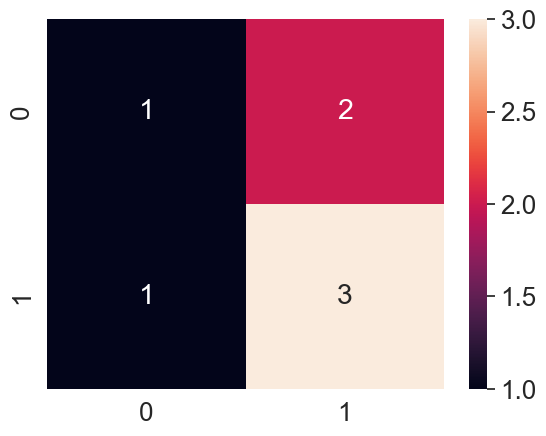

In [50]:
cf_matrix = confusion_matrix(y_test, rfc.predict(X_test_scaled))
sns.heatmap(cf_matrix, annot=True);

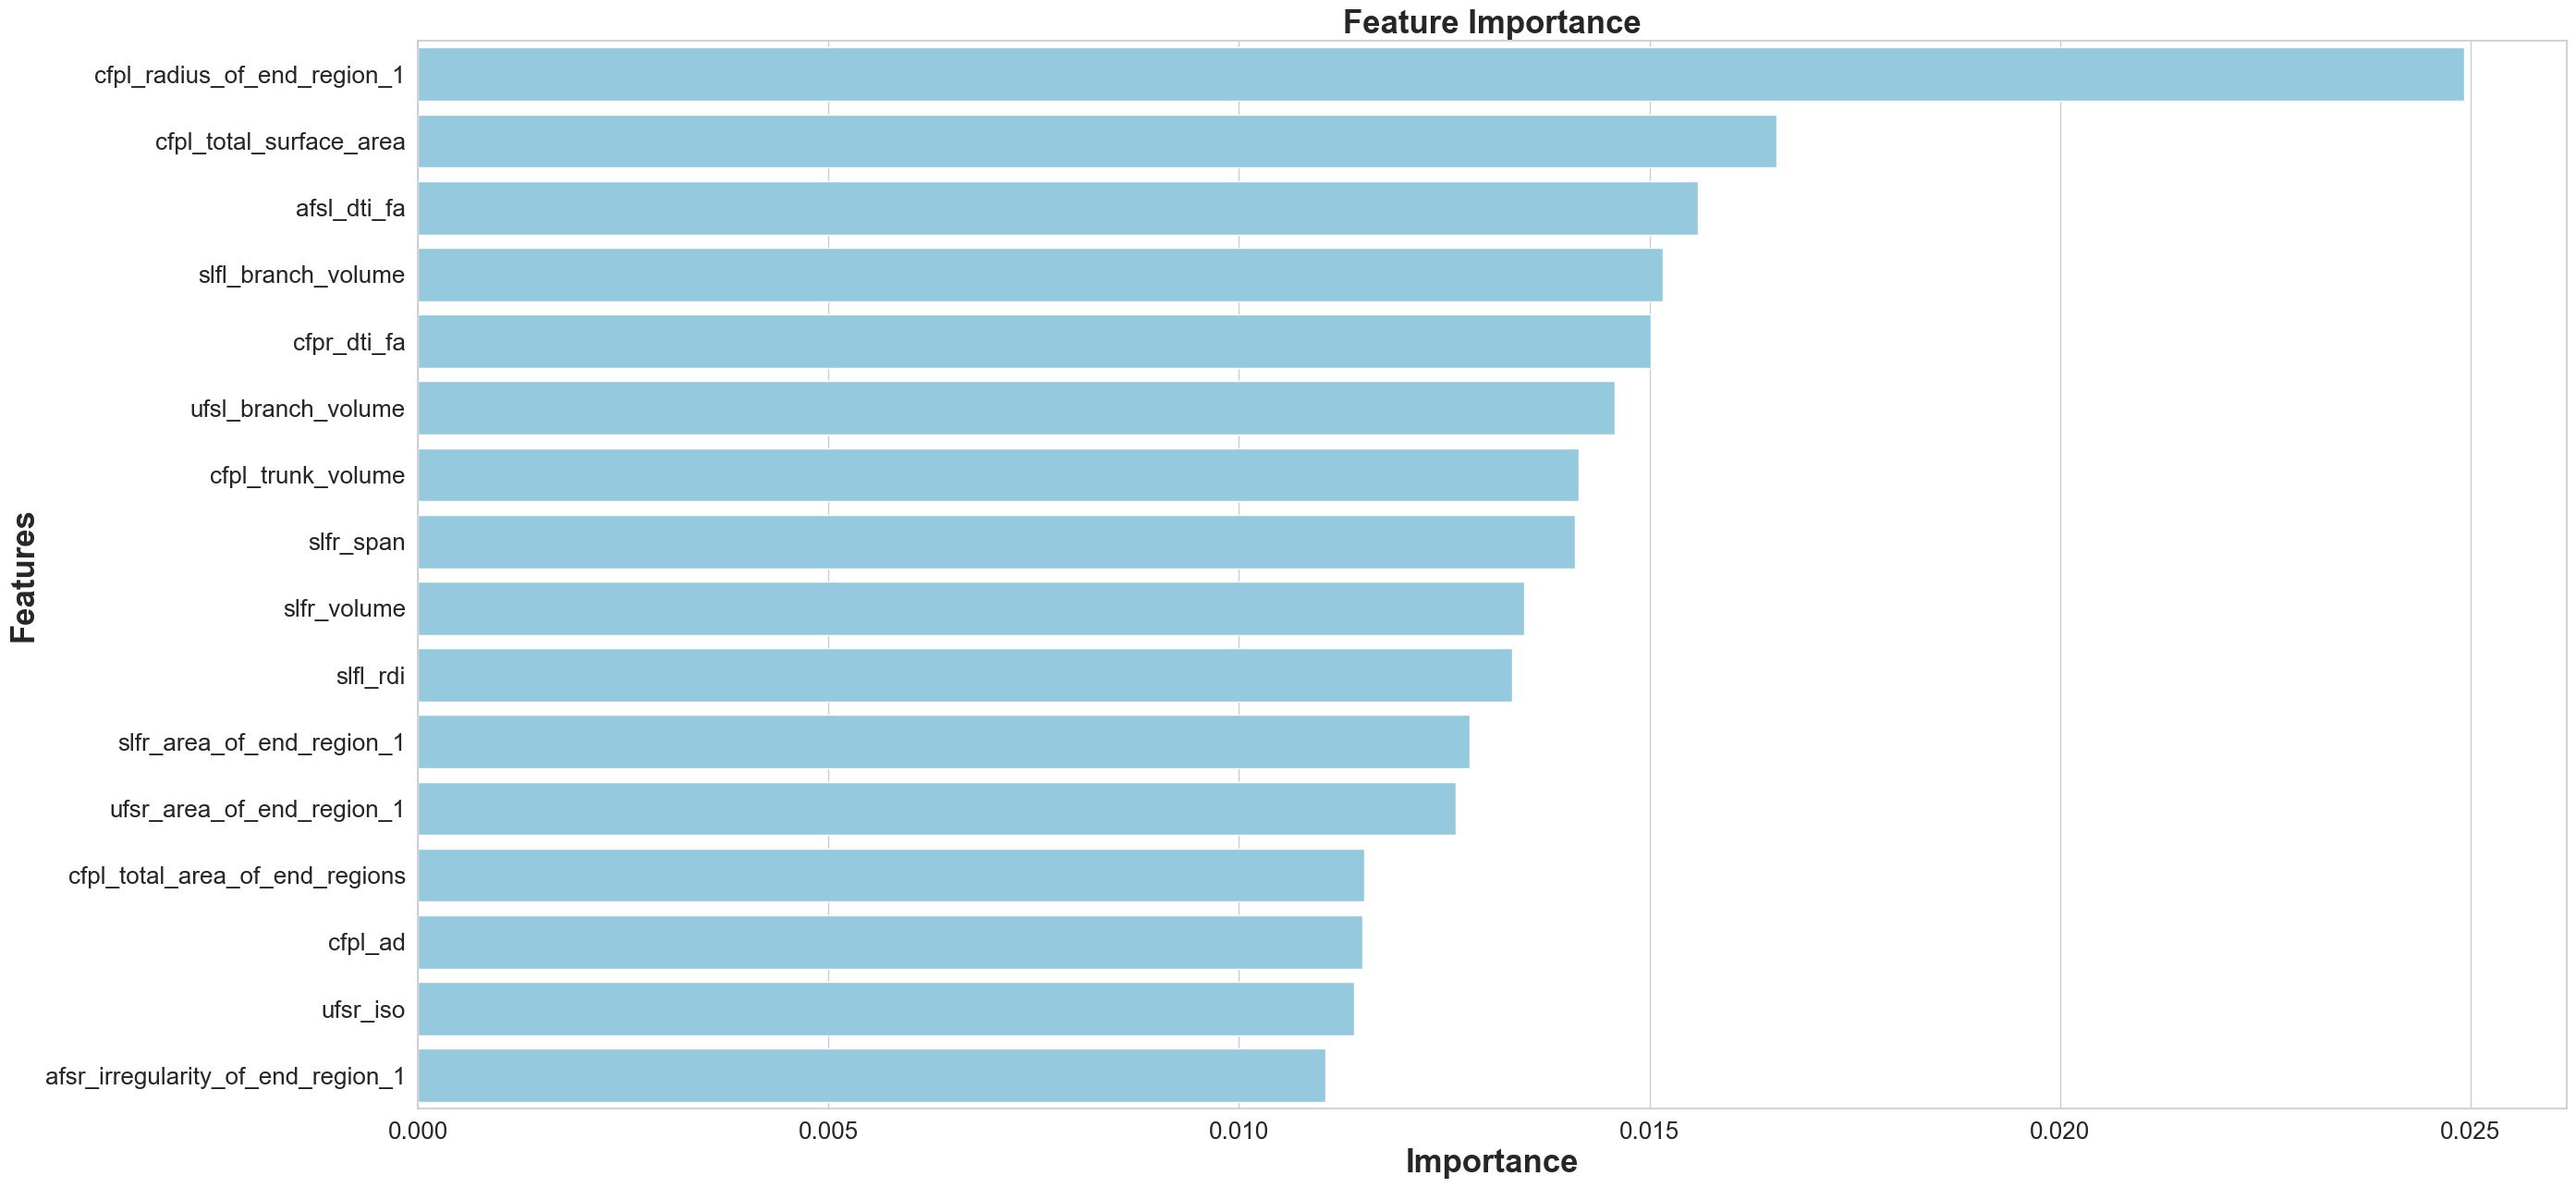

None

,Features,Gini-Importance
0,cfpl_radius_of_end_region_1,0.024927
1,cfpl_total_surface_area,0.016547
2,afsl_dti_fa,0.015592
3,slfl_branch_volume,0.015165
4,cfpr_dti_fa,0.015018
5,ufsl_branch_volume,0.014572
6,cfpl_trunk_volume,0.014138
7,slfr_span,0.014095
8,slfr_volume,0.013475
9,slfl_rdi,0.013329


In [51]:
feats = {}
for feature, importance in zip(df.columns, rfc.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'][:16], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances[:16])

### Decision Tree Classifier

In [56]:
componentes = 12 # puede ser None o un número entero o un float entre 0 y 1 que representa la varianza acumulada que se quiere explicar

In [57]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# instanciemos el modelo y entremoslo en el conjunto de autos
arbol = DecisionTreeClassifier(criterion='gini', max_depth=componentes, min_samples_leaf=1, min_samples_split=2, ccp_alpha=0)
arbol.fit(X_scaled,y_train)
accuracy_score(y_train, arbol.predict(X_scaled))

1.0

In [58]:
# veamos que tan bien le fue a este modelo
y_test = y_test.astype(y_train.dtype)
print(classification_report(y_true=y_test,y_pred=arbol.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.60      0.75      0.67         4

    accuracy                           0.57         7
   macro avg       0.55      0.54      0.53         7
weighted avg       0.56      0.57      0.55         7



In [63]:
cm = confusion_matrix(y_test, arbol.predict(X_test_scaled)) 
metricas = balanced_accuracy(cm)
print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas[2],4))) 

Matriz de confusion del modelo es:
[[1 2]
 [1 3]]
Sensibilidad del modelo es de: 0.6
Especificidad del modelo es de: 0.5
BA del modelo es de: 0.55


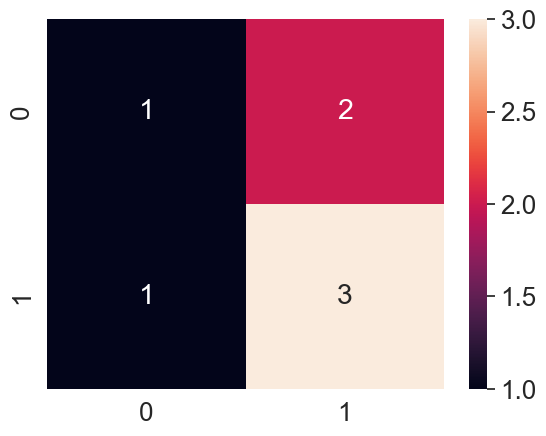

In [59]:
cf_matrix = confusion_matrix(y_test, arbol.predict(X_test_scaled))
sns.heatmap(cf_matrix, annot=True);

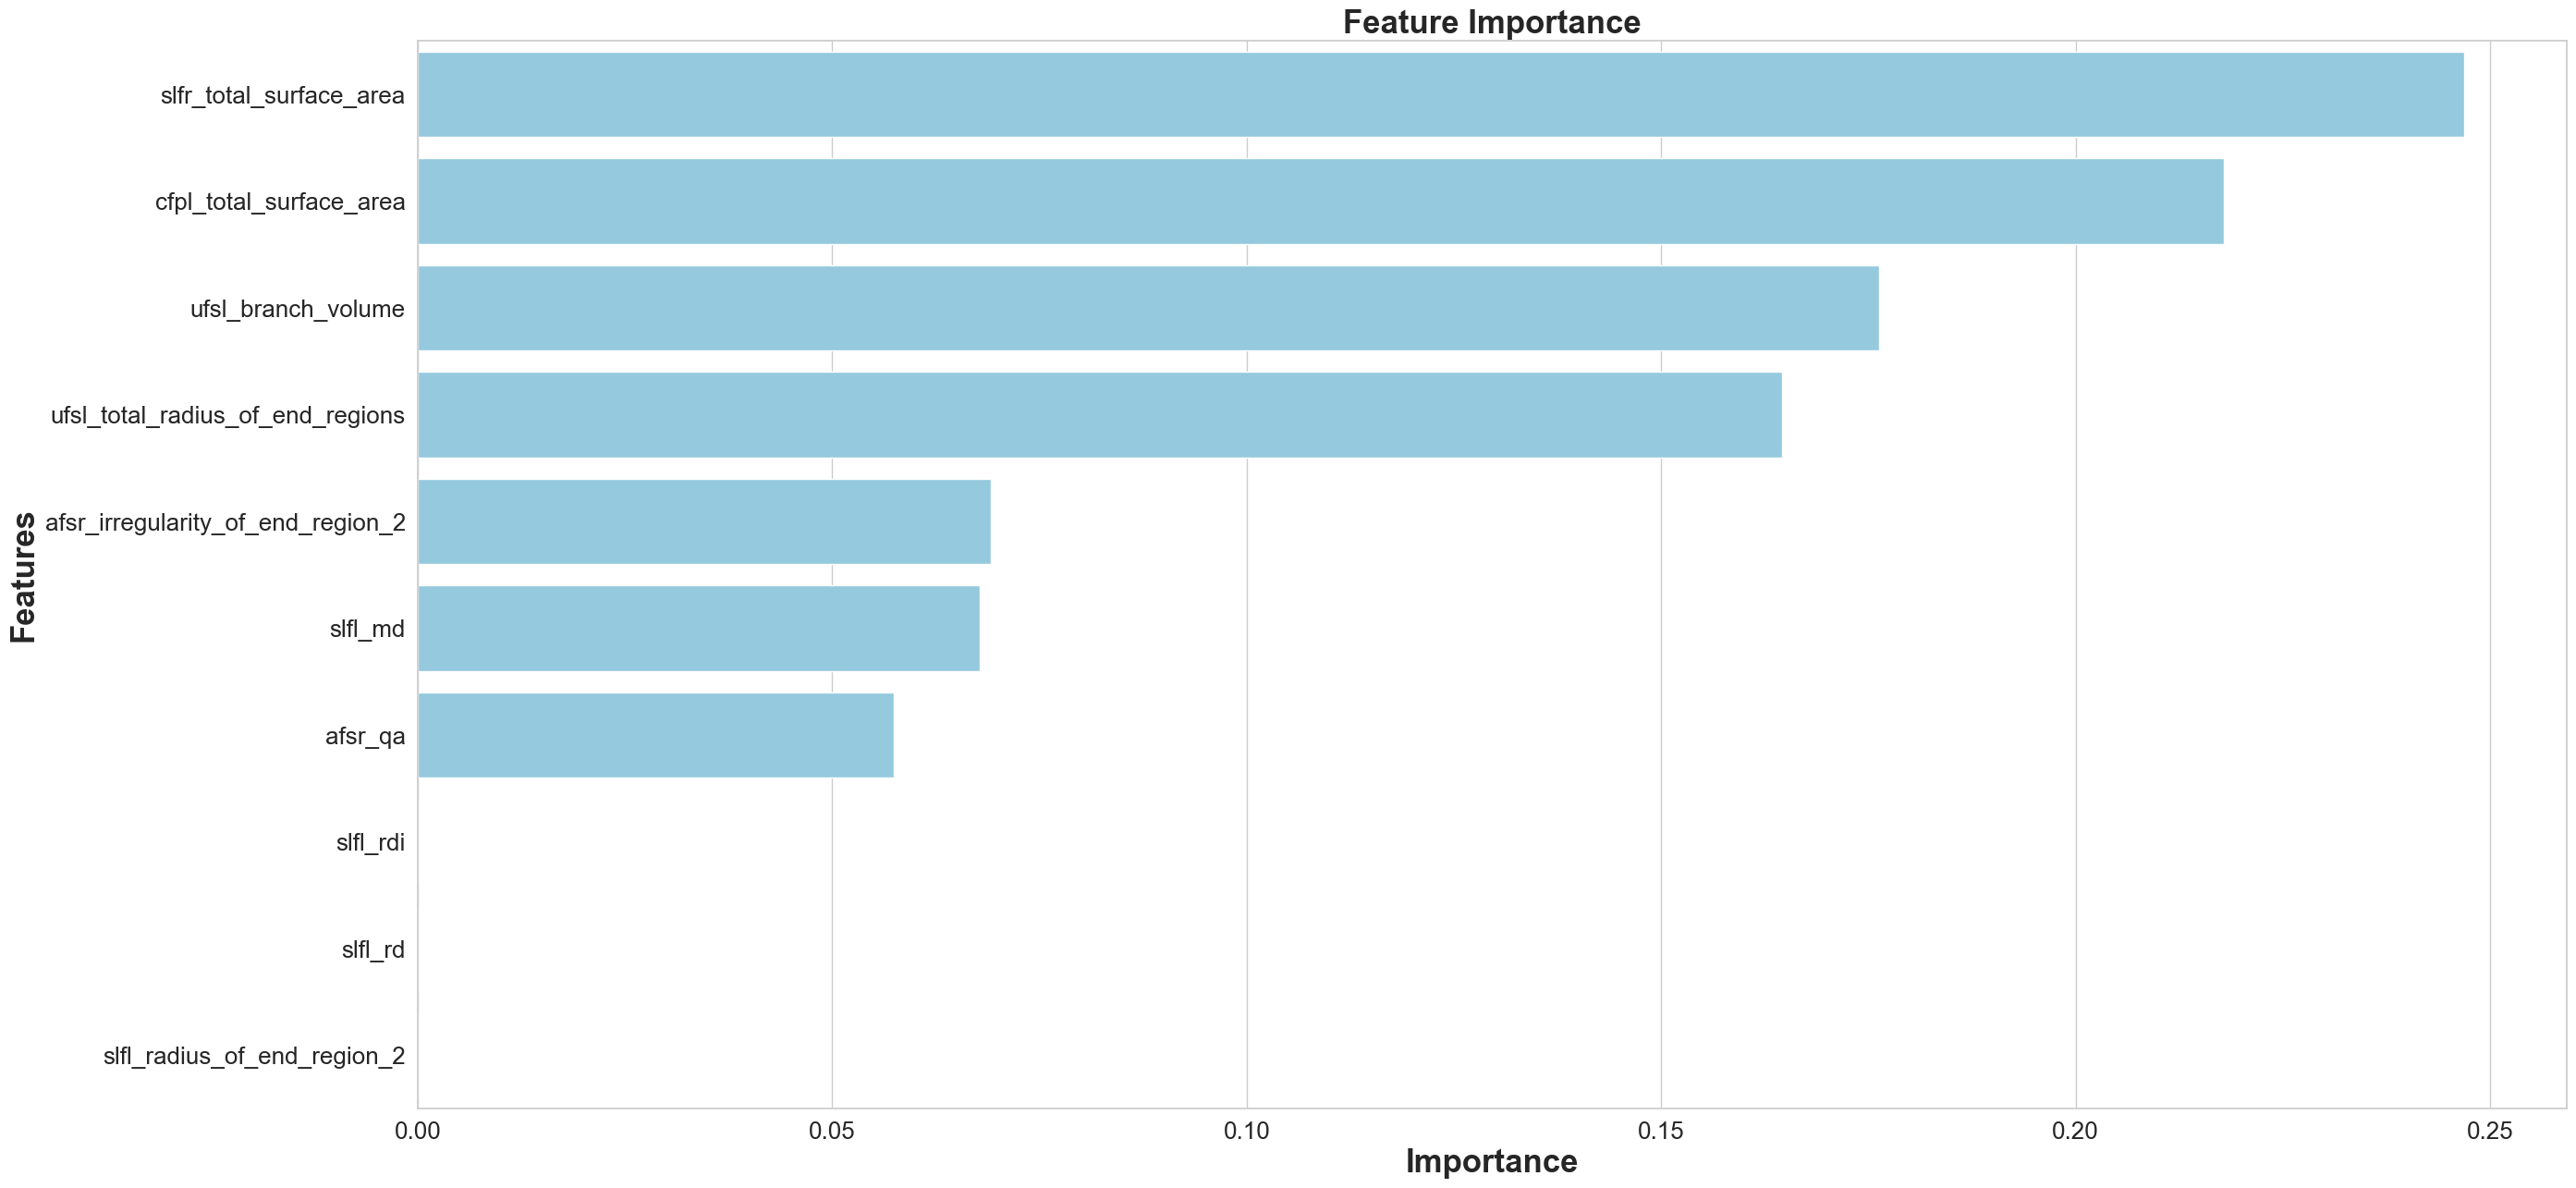

None

,Features,Gini-Importance
0,slfr_total_surface_area,0.246924
1,cfpl_total_surface_area,0.217896
2,ufsl_branch_volume,0.176253
3,ufsl_total_radius_of_end_regions,0.164616
4,afsr_irregularity_of_end_region_2,0.069112
5,slfl_md,0.067783
6,afsr_qa,0.057416
7,slfl_rdi,0.000000
8,slfl_rd,0.000000
9,slfl_radius_of_end_region_2,0.000000


In [60]:
feats = {}
for feature, importance in zip(df.columns, arbol.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'][:10], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances[:10])